In [1]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [3]:
import torch as t

In [20]:
# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    root='/cifar/', 
                    train=True, 
                    download=True,
                    transform=transform)

trainloader = t.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
                    '/cifar/',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=8, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
(data,label) = trainset[100]
print(classes[label])

ship


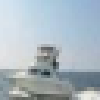

In [6]:
show((data+1)/2).resize((100,100))

       frog        ship         cat         dog


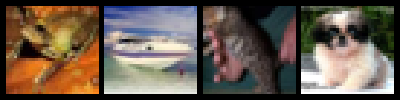

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [14]:
t.set_num_threads(8)
for epoch in range(5):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('图片序列：[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

图片序列：[1,  2000] loss: 1.205
图片序列：[1,  4000] loss: 1.193
图片序列：[1,  6000] loss: 1.218
图片序列：[1,  8000] loss: 1.180
图片序列：[1, 10000] loss: 1.177
图片序列：[1, 12000] loss: 1.163
图片序列：[2,  2000] loss: 1.070
图片序列：[2,  4000] loss: 1.123
图片序列：[2,  6000] loss: 1.111
图片序列：[2,  8000] loss: 1.088
图片序列：[2, 10000] loss: 1.089
图片序列：[2, 12000] loss: 1.089
图片序列：[3,  2000] loss: 1.009
图片序列：[3,  4000] loss: 1.031
图片序列：[3,  6000] loss: 1.024
图片序列：[3,  8000] loss: 1.040
图片序列：[3, 10000] loss: 1.037
图片序列：[3, 12000] loss: 1.036
图片序列：[4,  2000] loss: 0.938
图片序列：[4,  4000] loss: 0.946
图片序列：[4,  6000] loss: 0.974
图片序列：[4,  8000] loss: 1.000
图片序列：[4, 10000] loss: 0.979
图片序列：[4, 12000] loss: 0.975
图片序列：[5,  2000] loss: 0.867
图片序列：[5,  4000] loss: 0.934
图片序列：[5,  6000] loss: 0.917
图片序列：[5,  8000] loss: 0.945
图片序列：[5, 10000] loss: 0.938
图片序列：[5, 12000] loss: 0.931
Finished Training


实际的label:       cat     ship     ship    plane     frog     frog      car     frog


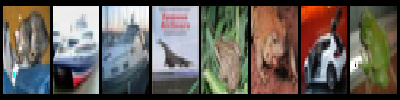

In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(8)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

In [23]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(8)))

预测结果:    cat  ship  ship  ship  frog  frog   cat  frog
